## IBM Stock Prediction - LSTM vs GRU

Saham merupakan salah satu pilihan investasi yang menarik karena dapat diperoleh untung yang besar dibandingkan dengan usaha lainnya. Untuk meminimalkan resiko kerugian, diperlukan perhatian yang jeli terhadap pergerakan saham dan perkembangan pasar modal merupakan salah satu indikator yang perlu dipantau. Dengan teknologi pemrosesan prediksi dan pembelajaran mesin saat ini, identifikasi prediksi harga saham dapat dilakukan secara otomatis. Deep Learning merupakan salah satu bagian dari pembelajaran mesin, dan memiliki akurasi pengenalan yang tinggi dengan data yang sangat banyak. Proyek ini menggunakan history harga saham dari IBM dan membandingkan metode RNN antara LSTM dan GRU untuk melakukan prediksi terhadap nilai saham dari IBM. 

Data yang digunakan untuk proyek ini diambil dari Yahoo Finance: [IBM - Stock Price ](https://finance.yahoo.com/quote/IBM/history?period1=1370390400&period2=1636070400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true). 

Pada dataset tersebut berisi sejarah harga stock pada perusahaan IBM dengan jumlah data sebanyak 10440 dengan 7 kolom yaitu Date, Open, High, Low, Close, Adj Close, dan Volume. Tetapi pada proyek ini kita akan hanya menggunakan kolom Date dan harga saham IBM pada waktu Close atau harga penutupan pada tanggal tertentu untuk membuat prediksi harga saham perusahaan IBM. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

**Import file IMB.csv**

In [2]:
from google.colab import files
  
uploaded = files.upload()

Saving IBM.csv to IBM.csv


**Membaca file IMB.csv**

In [3]:
df = pd.read_csv('IBM.csv')
df.head(-5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-06-05,13.892208,13.951960,13.593451,13.623327,4.504086,2735081
1,1980-06-06,13.653203,13.832457,13.653203,13.653203,4.513962,1353106
2,1980-06-09,13.653203,13.742830,13.533700,13.563576,4.484333,1330094
3,1980-06-10,13.563576,13.802581,13.533700,13.742830,4.543598,1548080
4,1980-06-11,13.742830,13.951960,13.683078,13.862333,4.583107,2138861
...,...,...,...,...,...,...,...
10435,2021-10-22,122.418739,124.521988,121.042068,122.256210,122.256210,12114981
10436,2021-10-25,121.921608,122.992355,121.357552,122.026772,122.026772,6667204
10437,2021-10-26,121.912048,122.657745,121.185471,121.539200,121.539200,8912861
10438,2021-10-27,121.835564,122.256210,119.512428,119.665390,119.665390,7294176


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10445 entries, 0 to 10444
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10445 non-null  object 
 1   Open       10445 non-null  float64
 2   High       10445 non-null  float64
 3   Low        10445 non-null  float64
 4   Close      10445 non-null  float64
 5   Adj Close  10445 non-null  float64
 6   Volume     10445 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 571.3+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10445.000000,10445.000000,10445.000000,10445.000000,10445.000000,1.044500e+04
mean,79.714486,80.462046,79.005797,79.739367,55.715512,6.917879e+06
std,54.875264,55.279987,54.501255,54.899031,45.394472,4.511500e+06
min,9.799235,9.978489,9.709608,9.799235,4.149564,0.000000e+00
25%,27.127151,27.336281,26.888145,27.127151,12.582995,4.095822e+06
50%,79.063095,79.894836,78.365204,79.110901,50.257805,5.857286e+06
75%,122.695984,123.661568,121.663483,122.801147,101.108559,8.411304e+06
max,205.908218,206.405350,204.875717,206.309753,149.120041,7.263916e+07


**Memvisualisasikan Dataset Berdasarkan Harga Close**

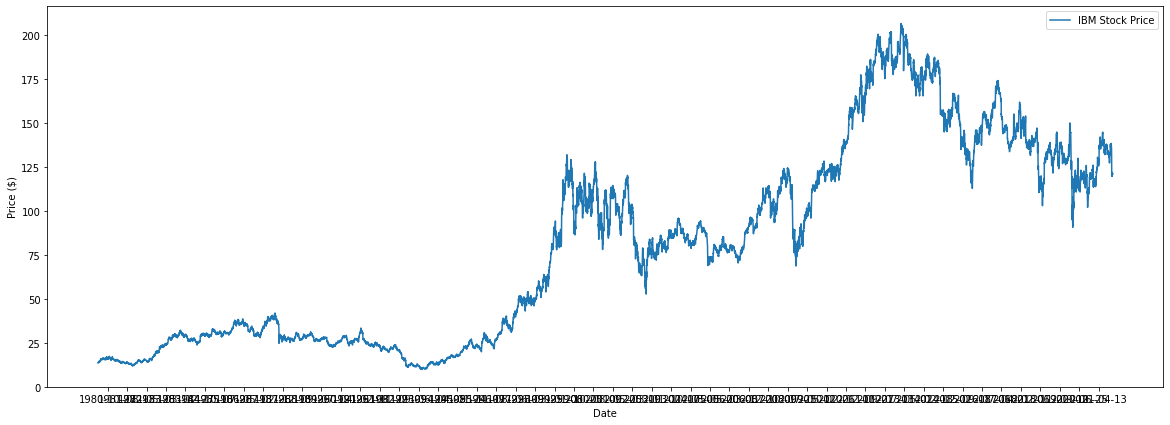

In [6]:
df['Close'] = df['Close'].astype(float)

plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['Close'].values, label = 'IBM Stock Price')
plt.xticks(np.arange(100,df.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

## Data Preparation
Teknik data preparation yang dilakukan adalah membagi dataset menjadi data latih (train) dan data  uji (test).

In [7]:
num_shape = 10000

train = df.iloc[:num_shape, 1:2].values
test = df.iloc[num_shape:, 1:2].values

Selanjutnya melakukan scaling untuk fitur-fitur menggunakan normalisai dengan menggunakan fungsi MinMaxScaler.

In [8]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

Sekarang kita ambil satu baris dan potong dengan window sebanyak 60 elemen

In [9]:
X_train = []

y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

# **Menggunakan model LSTM**

**Membuat model Sequential LSTM**

In [10]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

Model LSTM dilatih dengan menggunakan optimizer adam dan loss yang digunakan adalah MSE, epoch sebanyak 20 dan batch size 32.

In [11]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 20, batch_size = 32);

Epoch 1/20
311/311 [==============================] - 30s 60ms/step - loss: 0.0056
Epoch 2/20
311/311 [==============================] - 19s 60ms/step - loss: 0.0022
Epoch 3/20
311/311 [==============================] - 19s 60ms/step - loss: 0.0020
Epoch 4/20
311/311 [==============================] - 19s 60ms/step - loss: 0.0015
Epoch 5/20
311/311 [==============================] - 19s 60ms/step - loss: 0.0015
Epoch 6/20
311/311 [==============================] - 19s 60ms/step - loss: 0.0014
Epoch 7/20
311/311 [==============================] - 19s 60ms/step - loss: 0.0012
Epoch 8/20
311/311 [==============================] - 19s 60ms/step - loss: 0.0012
Epoch 9/20
311/311 [==============================] - 19s 60ms/step - loss: 0.0012
Epoch 10/20
311/311 [==============================] - 19s 60ms/step - loss: 0.0010
Epoch 11/20
311/311 [==============================] - 19s 60ms/step - loss: 0.0011
Epoch 12/20
311/311 [==============================] - 19s 60ms/step - loss: 9.1184e-

**Melakukan Prediksi**

In [12]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [13]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

**Hasil MSE, MAE, RSME dari perbedaan antara prediksi dengan test**

In [14]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 17.25563949688032
MAE: 3.064625792357576
RMSE: 4.153990791621994


**Memvisualisasikan hasil prediksi harga saham IBM dengan harga saham aslinya dengan metode LSTM**

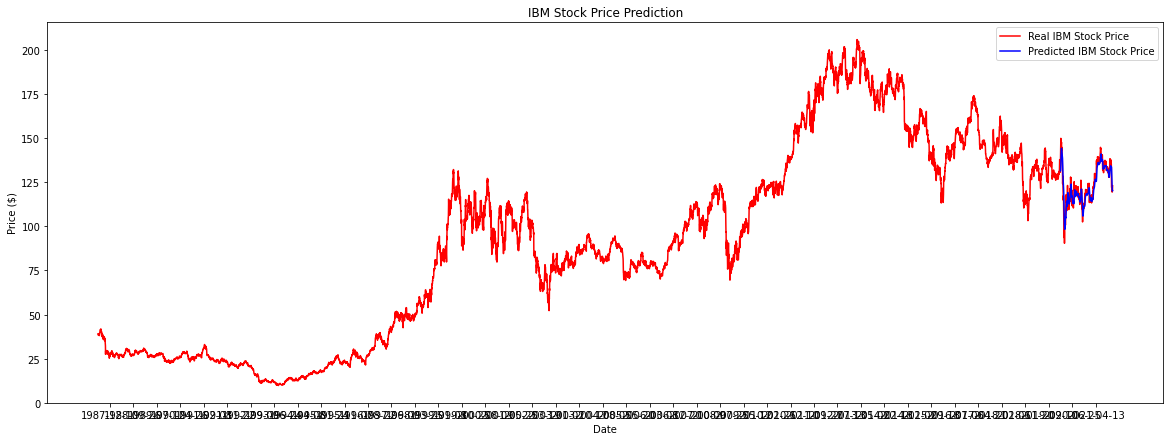

In [15]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1800:], df_volume[1800:], color = 'red', label = 'Real IBM Stock Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted IBM Stock Price')
plt.xticks(np.arange(100,df[1800:].shape[0],200))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# **GRU**

**Membuat model Sequential GRU**

In [16]:
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 50)            7950      
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)               

Model GRU dilatih dengan menggunakan optimizer sgd dan loss yang digunakan adalah MSE, epoch sebanyak 20 dan batch size 32.

In [17]:
modelGRU.compile(optimizer='sgd', loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
311/311 [==============================] - 24s 57ms/step - loss: 0.0241
Epoch 2/20
311/311 [==============================] - 18s 57ms/step - loss: 0.0034
Epoch 3/20
311/311 [==============================] - 18s 57ms/step - loss: 0.0031
Epoch 4/20
311/311 [==============================] - 18s 57ms/step - loss: 0.0029
Epoch 5/20
311/311 [==============================] - 17s 56ms/step - loss: 0.0026
Epoch 6/20
311/311 [==============================] - 17s 55ms/step - loss: 0.0025
Epoch 7/20
311/311 [==============================] - 17s 56ms/step - loss: 0.0023
Epoch 8/20
311/311 [==============================] - 17s 56ms/step - loss: 0.0023
Epoch 9/20
311/311 [==============================] - 18s 56ms/step - loss: 0.0023
Epoch 10/20
311/311 [==============================] - 18s 57ms/step - loss: 0.0023
Epoch 11/20
311/311 [==============================] - 18s 57ms/step - loss: 0.0021
Epoch 12/20
311/311 [==============================] - 18s 57ms/step - loss: 0.0021
E

In [18]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

**Hasil MSE, MAE, RSME dari perbedaan antara prediksi dengan test**

In [19]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 29.688134235228173
MAE: 3.7088897904955247
RMSE: 5.448681880531123


**Memvisualisasikan hasil prediksi harga saham IBM dengan harga saham aslinya dengan metode GRU**

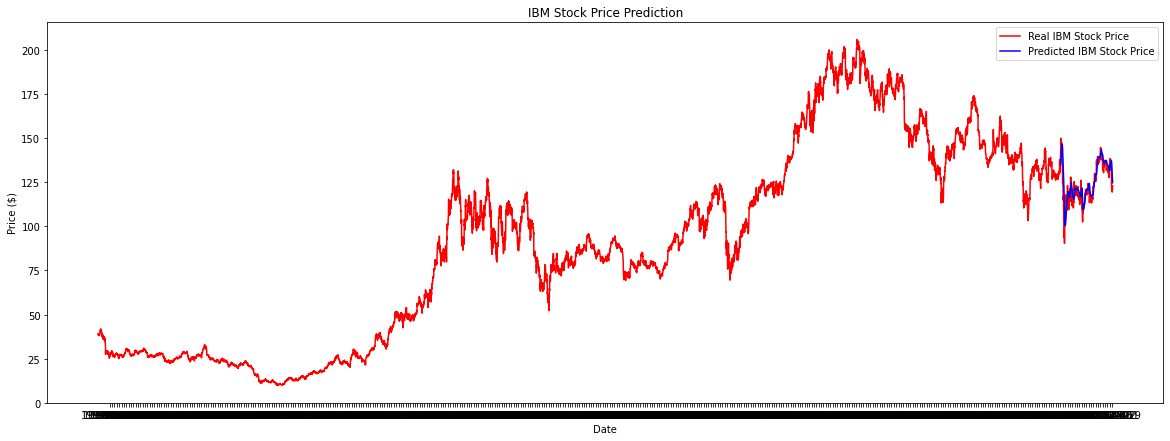

In [20]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1800:], df_volume[1800:], color = 'red', label = 'Real IBM Stock Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted IBM Stock Price')
plt.xticks(np.arange(100,df[1800:].shape[0],20))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()